In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from albumentations import *
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.metrics import *
from sklearn.model_selection import KFold
from skmultilearn.model_selection import IterativeStratification

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model, Model

In [2]:
BASE_DIR = "data"

SHAPE      = (224, 224, 3)
BATCH_SIZE = 27
EPOCHS     = 5
N_SPLITS   = 3
SEED       = 1881

OVERSAMPLE_RATIO        = 15
TRAIN_TEST_RATIO        = 0.2
CORONA_TRAIN_TEST_RATIO = 0.5

# tf reduce memory alignment(model size) & faster forward propagation
tf.compat.v1.disable_eager_execution()

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [3]:
train_csv = pd.read_csv(os.path.join(BASE_DIR, "CheXpert-v1.0-small/train.csv"))
train_csv.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
metadata = pd.read_csv(os.path.join(BASE_DIR, "covid-chestxray-dataset", "metadata.csv"))
metadata = metadata[metadata["modality"]=="X-ray"]
metadata = metadata[metadata["finding"].isin(["COVID-19", "ARDS", "SARS"])]
metadata = metadata.reset_index(drop=True)
metadata.head()

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
class DataGenerator:
    
    """
    data_csv                --> pandas.DataFrame. CheXpert Train CSV
    metadata                --> pandas.DataFrame. covid-chestxray-dataset <https://github.com/ieee8023/covid-chestxray-dataset>
    input_shape             --> TUPLE. Target image size
    batch_size              --> INT. Yielding data size for every iteration
    orders                  --> LIST. Which images will be used. max=>len(all_images).
    base_dir                --> STR. Relative path of data directory.
    seed                    --> INT. This makes dataset generator more reproduciable 
    oversample_ratio        --> INT. Oversample minor data by "oversample_ratio" times.
    train_test_ratio        --> FLOAT. How much of data will be used as test set.
    corona_train_test_ratio --> FLOAT. How much of data will be used as test set.
    augment                 --> BOOL. Augment data or not.
    """
    
    def __init__(self, data_csv, metadata, input_shape, batch_size, orders, base_dir, seed, oversample_ratio, train_test_ratio, corona_train_test_ratio, augment=True):
        self.DATA_CSV   = data_csv  
        self.METADATA   = metadata
        
        self.SHAPE      = input_shape
        self.BATCH_SIZE = batch_size
        self.arr        = orders
        self.SEED       = seed  
        self.AUG        = augment

        self.OS_RATIO     = oversample_ratio
        self.TT_RATIO     = train_test_ratio
        self.CORONA_RATIO = corona_train_test_ratio
        
        self.BASE_DIR   = base_dir
        
        self.light_aug_probs  = [0.3, 0.5, 0.2, 0.2]
        self.light_aug_limits = [0.05, 0.05, 5]
        
        self.hard_aug_probs  = [0.5, 0.5, 0.8, 0.8]
        self.hard_aug_limits = [0.15, 0.15, 15]
        
        self.DATA_CSV   = self.drop_uncertain_data(self.DATA_CSV)
        self.DATA_CSV   = self.drop_not_detected_disease_case(self.DATA_CSV)
        self.DATA_CSV   = self.DATA_CSV.reset_index(drop=True)
        
        self.paths_chexpert, self.labels_chexpert = self.get_paths_n_labels(self.DATA_CSV)
        self.paths_corona  , self.labels_corona   = self.get_paths_n_labels_corona(self.METADATA, self.DATA_CSV)

        self.paths_corona_train, self.labels_corona_train, self.paths_corona_test, self.labels_corona_test = self.iterative_train_test_split(np.array(self.paths_corona), np.array(self.labels_corona).astype(np.float32), test_size=self.CORONA_RATIO)

        self.paths_corona_train  = np.vstack([self.paths_corona_train]*self.OS_RATIO)
        self.labels_corona_train = np.vstack([self.labels_corona_train]*self.OS_RATIO)
    
    def get_paths_n_labels_corona(self, metadata, data_csv):
        paths  = []
        labels = []
        
        for f_name in os.listdir(os.path.join(self.BASE_DIR, "covid-chestxray-dataset", "images")):
            get_data_row = metadata[metadata["filename"]==f_name]
            if not get_data_row.empty:
                label = np.zeros((len(metadata["finding"].unique())))
                label_idx = np.where(get_data_row['finding'].values==metadata["finding"].unique())[0][0]
                label[label_idx] = 1
                labels.append(label)

                paths.append(os.path.join(self.BASE_DIR, "covid-chestxray-dataset", "images", f_name))
        
        labels = np.array(labels)
        labels = np.concatenate((labels, np.zeros((len(labels), len(data_csv.columns[5:])))), axis=1)
        return np.array(paths).reshape((len(paths),1)), np.array(labels).reshape((len(labels), len(self.METADATA["finding"].unique())+len(self.DATA_CSV.columns[5:])))
    
    def drop_uncertain_data(self, data_csv):
        to_drop_indexes = set()

        for col in data_csv.columns:
            to_drop_indexes.update(data_csv[data_csv[col]==-1.0].index)

        data_csv = data_csv.drop(list(to_drop_indexes), axis=0)
        data_csv = data_csv.reset_index(drop=True)
        return data_csv 
    
    def drop_not_detected_disease_case(self, data_csv): 
        d = data_csv.iloc[:,5:-1].apply(lambda x: 1 if x.max()!=1 else 0, axis=1)
        to_drop_indexes = d[d.values==1].index
        
        data_csv = data_csv.drop(list(to_drop_indexes), axis=0)
        data_csv = data_csv.reset_index(drop=True)
        return data_csv 
    
    def get_paths_n_labels(self, data_csv):
        data_csv = data_csv.fillna(0)
        
        paths  = np.array(self.BASE_DIR + "/" + data_csv["Path"])
        labels = np.array(data_csv.iloc[:,5:]).astype(np.float32)
        labels = np.concatenate((np.zeros((len(labels),3)), labels), axis=1)
        return np.array(paths).reshape((len(paths),1)), np.array(labels).reshape((len(labels), len(self.METADATA["finding"].unique())+len(self.DATA_CSV.columns[5:])))

    def augmenting(self, img, aug_probs, aug_limits):
        if self.AUG:
            augment = Compose([HorizontalFlip(p=aug_probs[0]),
                               CLAHE(p=aug_probs[1]),
                               RandomBrightnessContrast(p=aug_probs[2]),
                               ShiftScaleRotate(p=aug_probs[3], shift_limit=aug_limits[0], scale_limit=aug_limits[1], rotate_limit=aug_limits[2])])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.paths_chexpert, self.labels_chexpert

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
    
    def iterative_train_test_split(self, X, y, test_size):
        """Iteratively stratified train/test split
        Parameters
        ----------
        test_size : float, [0,1]
            the proportion of the dataset to include in the test split, the rest will be put in the train set
        Returns
        -------
        X_train, y_train, X_test, y_test
            stratified division into train/test split
        """

        stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
        train_indexes, test_indexes = next(stratifier.split(y, y))
        
        X_train, y_train = X[train_indexes], y[train_indexes]
        X_test, y_test = X[test_indexes], y[test_indexes]

        return X_train, y_train, X_test, y_test
    
    def split_train_test(self, get): 
        img_paths, labels = self.get_shuffled_data()
        x_train, y_train, x_test, y_test = self.iterative_train_test_split(np.array(img_paths), np.array(labels).astype(np.float32), test_size=self.TT_RATIO)
        
        if get=='train':
            x_train_all = np.concatenate((self.paths_corona_train , x_train), axis=0)
            y_train_all = np.concatenate((self.labels_corona_train, y_train), axis=0)
            
            np.random.seed(self.SEED) 
            np.random.shuffle(x_train_all)
        
            np.random.seed(self.SEED) 
            np.random.shuffle(y_train_all)
        
            return x_train_all, y_train_all
        
        elif get=='test_chexpert':
            return x_test, y_test
        
        elif get=='test_corona':
            return self.paths_corona_test, self.labels_corona_test
            
        elif get=='test_all':
            x_test_all = np.concatenate((self.paths_corona_test , x_test), axis=0)
            y_test_all = np.concatenate((self.labels_corona_test, y_test), axis=0)
            return x_test_all, y_test_all
                      
    def data_generator(self):
        self.t_img_paths, self.t_labels = self.split_train_test(get="train")
        
        while True:
            x_batch = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y_batch = np.empty((self.BATCH_SIZE, len(self.METADATA["finding"].unique())+len(self.DATA_CSV.columns[5:])), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                
                # y 
                label = self.t_labels[id_]
                
                # x
                img_path = self.t_img_paths[id_][0]
                img = cv2.imread(img_path)
                
                if 1 in label[:3]:
                    img = self.augmenting(img, self.hard_aug_probs, self.hard_aug_limits)
                else:
                    img = self.augmenting(img, self.light_aug_probs, self.light_aug_limits)
                    
                img = cv2.resize(img, self.SHAPE[:2])
                img = np.divide(img, 255)

                # Store the values    
                x_batch[ix] = img
                y_batch[ix] = label

            yield x_batch, y_batch

[[[0.11764706 0.11764706 0.11764706]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.11764706 0.11764706 0.11764706]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  ...
  [0.03529412 0.03529412 0.03529412]
  [0.01568628 0.01568628 0.01568628]
  [0.02745098 0.02745098 0.02745098]]

 [[0.11764706 0.11764706 0.11764706]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.05098039 0.05098039 0.05098039]]

 ...

 [[0.14117648 0.14117648 0.14117648]
  [0.03529412 0.03529412 0.03529412]
  [0.01960784 0.01960784 0.01960784]
  ...
  [0.32941177 0.32941177 0.32941177]
  [0.3882353  0.3882353  0.3882353 ]
  [0.3764706  0.3764706  0.3764706 ]]

 [[0.15686275 0.15686275 0.15686275]
  [0.08235294 0.08235294 0.08235294]


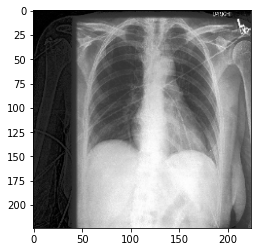

In [6]:
sample_dataset = DataGenerator(train_csv, metadata, SHAPE, BATCH_SIZE, range(106652), BASE_DIR, SEED, OVERSAMPLE_RATIO, TRAIN_TEST_RATIO, CORONA_TRAIN_TEST_RATIO, augment=True)
t = sample_dataset.split_train_test("train")

for ix, data in enumerate(sample_dataset.data_generator()):
    img_batch, label_batch = data
    print(img_batch[0])
    print(img_batch[0].shape)
    print("-"*10)
    print(label_batch[0])
    print(label_batch[0].shape)
    print("-"*10)
    plt.imshow(img_batch[0])
    plt.show()

    if ix==0:
        break

In [7]:
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))


def f1_corona(y_true, y_pred):
    print(y_true.shape, y_pred)
    return K.max(K.gather(y_true, [0,1,2]))

In [8]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [9]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [10]:
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = SeparableConv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = SeparableConv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [11]:
def create_model(out_neuron_number):
    
    dropRate = 0.5
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(out_neuron_number, activation='sigmoid')(x)
   
    model = Model(init, y)
    return model

In [12]:
model = create_model(t[1].shape[1])
model.summary()

W0321 16:34:42.255116 17460 deprecation.py:506] From C:\Users\pc\Anaconda3\envs\covid19\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

global_average_pooling2d_1 (Glo (None, 128)          0           activation_4[0][0]               
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 128)          0           activation_4[0][0]               
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, 1, 128)    0           global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, 1, 128)    0           global_max_pooling2d_1[0][0]     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 1, 16)     2064        reshape_2[0][0]                  
                                                                 reshape_3[0][0]                  
__________

In [13]:
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

for ix, (train_index, val_index) in enumerate(kf.split(range(t[1].shape[0]))):
                                               
    tg = DataGenerator(train_csv, metadata, SHAPE, BATCH_SIZE, train_index, BASE_DIR, SEED, OVERSAMPLE_RATIO, TRAIN_TEST_RATIO, CORONA_TRAIN_TEST_RATIO, augment=True)
    vg = DataGenerator(train_csv, metadata, SHAPE, BATCH_SIZE, val_index  , BASE_DIR, SEED, OVERSAMPLE_RATIO, TRAIN_TEST_RATIO, CORONA_TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=5,
                             mult_factor=2.)

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc', tf.keras.metrics.AUC()])
    
    if not os.path.exists("models"):
        os.makedirs("models")
        
    model_ckpt = "models/CORONA_DIAGNOSE_MODEL_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir=os.path.join("logs",f"fit_{ix}",f"{datetime.datetime.now().strftime('Y%m%d-%H%M%S')}"), update_freq='batch'), 
                 schedule] 
    
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(val_index)//BATCH_SIZE,
                        callbacks=callbacks)

Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.32363, saving model to models/CORONA_DIAGNOSE_MODEL_FOLD_0.h5
2633/2633 - 2294s - loss: 0.3069 - precision: 0.5925 - recall: 0.3372 - f1: 0.4262 - acc: 0.8679 - auc: 0.8481 - val_loss: 0.3236 - val_precision: 0.5192 - val_recall: 0.5272 - val_f1: 0.5219 - val_acc: 0.8596 - val_auc: 0.8514
Epoch 2/5

Epoch 00002: val_loss improved from 0.32363 to 0.31940, saving model to models/CORONA_DIAGNOSE_MODEL_FOLD_0.h5
2633/2633 - 1646s - loss: 0.2876 - precision: 0.6326 - recall: 0.3861 - f1: 0.4775 - acc: 0.8777 - auc: 0.8690 - val_loss: 0.3194 - val_precision: 0.5194 - val_recall: 0.5778 - val_f1: 0.5458 - val_acc: 0.8603 - val_auc: 0.8555
Epoch 3/5

Epoch 00003: val_loss did not improve from 0.31940
2633/2633 - 1487s - loss: 0.2821 - precision: 0.6413 - recall: 0.4038 - f1: 0.4936 - acc: 0.8802 - auc: 0.8745 - val_loss: 0.3537 - val_precision: 0.5232 - val_recall: 0.5594 - val_f1: 0.5395 - val_acc: 0.8617 - val_auc: 0.8502
Epoch 4/5

Epo

In [13]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

In [14]:
gen = DataGenerator(train_csv, metadata, SHAPE, BATCH_SIZE, range(1), BASE_DIR, SEED, OVERSAMPLE_RATIO, TRAIN_TEST_RATIO, CORONA_TRAIN_TEST_RATIO, augment=False).split_train_test("test_corona")

x_test = np.zeros((len(gen[0]),)+SHAPE, dtype=np.float32)
y_test = np.zeros((len(gen[1]), t[1].shape[1]), dtype=np.float32)

for ix, path in tqdm(enumerate(gen[0])):
    img = cv2.imread(path[0])
    img = cv2.resize(img, SHAPE[:2])
    img = np.divide(img,255)

    label = gen[1][ix]

    x_test[ix] = img
    y_test[ix] = label

58it [00:02, 24.15it/s]


In [15]:
models = []
scores = []
for i in range(N_SPLITS):
    model = load_model("models/CORONA_DIAGNOSE_MODEL_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)
    scores.append(score[-1])
    models.append(model)

[0.09753057103732536, 0.7160441, 0.85216343, 0.7781955, 0.9705882, 0.97555923]
[0.3283351844754712, 0.33157897, 0.15504807, 0.20915028, 0.9300203, 0.437853]
[0.0834482420107414, 0.85215056, 0.8064904, 0.8285714, 0.98073024, 0.95911676]


In [16]:
best_model_idx = np.array(scores).argmax()
best_model = models[best_model_idx]
print(best_model_idx)

0


In [17]:
y_preds = threshold_arr(best_model.predict(x_test, verbose=0))

In [18]:
results = precision_recall_fscore_support(y_test, y_preds, average='samples')
acc = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds, average='samples')

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y_test, y_preds))

ROC_AUC: 0.9084051724137931, Accuracy: 0.8275862068965517, F1_Score: 0.8275862068965517, Precision: 0.8275862068965517, Recall: 0.8275862068965517




C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      0.92      0.91        51
           1       0.00      0.00      0.00         2
           2       1.00      0.20      0.33         5
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0

   micro avg       0.83   

In [14]:
gen = DataGenerator(train_csv, metadata, SHAPE, BATCH_SIZE, range(1), BASE_DIR, SEED, OVERSAMPLE_RATIO, TRAIN_TEST_RATIO, CORONA_TRAIN_TEST_RATIO, augment=False).split_train_test("test_chexpert")

x_test = np.zeros((len(gen[0]),)+SHAPE, dtype=np.float32)
y_test = np.zeros((len(gen[1]), gen[1].shape[1]), dtype=np.float32)

for ix, path in tqdm(enumerate(gen[0])):
    img = cv2.imread(path[0])
    img = cv2.resize(img, SHAPE[:2])
    img = np.divide(img,255)

    label = gen[1][ix]

    x_test[ix] = img
    y_test[ix] = label

26497it [11:00, 40.10it/s] 


In [15]:
models = []
scores = []
for i in range(N_SPLITS):
    model = load_model("models/CORONA_DIAGNOSE_MODEL_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    score = model.evaluate(x_test, y_test, verbose=0)
    print(score)
    scores.append(score[-1])
    models.append(model)

[0.2828805414502088, 0.6251181, 0.4680678, 0.53364354, 0.8816561, 0.87509835]
[0.27998234422880736, 0.698226, 0.33533388, 0.45057017, 0.8820202, 0.87937045]
[0.27559177518615263, 0.68398255, 0.3964373, 0.49996075, 0.8853499, 0.88328624]


In [16]:
best_model_idx = np.array(scores).argmax()
best_model = models[best_model_idx]
print(best_model_idx)

2


In [18]:
y_preds = threshold_arr(best_model.predict(x_test, verbose=0))

In [19]:
results = precision_recall_fscore_support(y_test, y_preds, average='samples')
acc = accuracy_score(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds, average='samples')

print("ROC_AUC: {}, Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(roc_auc, acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y_test, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      desc         = f"{best_model_idx+1}. FOLD (BEST) - Multiclass",
                      normalize    = False,
                      target_names = sample_dataset.unique_labels,
                      title        = "Confusion Matrix")

ROC_AUC: 0.6142041573516255, Accuracy: 0.08095256066724535, F1_Score: 0.3620200532732746, Precision: 0.630901611503189, Recall: 0.2538378608196547




C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pc\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.56      0.44      0.50      4454
           4       0.00      0.00      0.00      1421
           5       0.28      0.10      0.15      3570
           6       0.33      0.03      0.05     10638
           7       0.00      0.00      0.00      1124
           8       0.48      0.04      0.08      7151
           9       0.00      0.00      0.00      1743
          10       0.00      0.00      0.00       783
          11       0.16      0.00      0.01      4750
          12       0.56      0.01      0.02      3014
          13       0.62      0.64      0.63     11167
          14       0.00      0.00      0.00       396
          15       0.23      0.04      0.07      1207
          16       0.78      0.46      0.58     14439

   micro avg       0.63   

NameError: name 'plot_confusion_matrix' is not defined